# Lending Club Case Study

                                                                                                     By
                                                                                                     - Rajagopal Shenoy G
                                                                                                     - Anindya Sudhir

## Objective

1. Identify the **risky loan applicants** using EDA, so that such loans can be reduced to cut down the amount of credit loss

2. To understand the **driving factors (or driver variables)** behind loan default, i.e. the variables which are strong indicators of default

In [1]:
# Import all necessary libraries
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

## Data Frame Analysis

In [2]:
loan = pd.read_csv("./loan.csv")
loan.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39717 entries, 0 to 39716
Columns: 111 entries, id to total_il_high_credit_limit
dtypes: float64(74), int64(13), object(24)
memory usage: 33.6+ MB


In [3]:
loan.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
0,1077501,1296599,5000,5000,4975.0,36 months,10.65%,162.87,B,B2,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
1,1077430,1314167,2500,2500,2500.0,60 months,15.27%,59.83,C,C4,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
2,1077175,1313524,2400,2400,2400.0,36 months,15.96%,84.33,C,C5,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
3,1076863,1277178,10000,10000,10000.0,36 months,13.49%,339.31,C,C1,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
4,1075358,1311748,3000,3000,3000.0,60 months,12.69%,67.79,B,B5,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN


### Univariate Analysis of Loan Repayment Status

Understand the loan repayment status of borrowers:

Fully Paid     32950
Charged Off     5627
Current         1140
Name: loan_status, dtype: int64


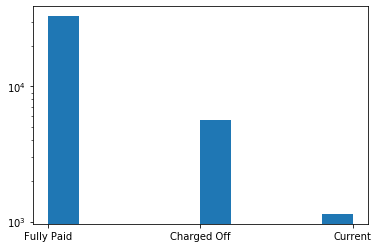

In [4]:
# How many loans are Charged-Off (Defaulted)

print(loan['loan_status'].value_counts())

plt.hist(loan['loan_status'])
plt.yscale('log')

- Rows with Loan Status as  Current cannot provide useful insights as one never knows which way those loans will go (get fully paid or defaulted)
- Hence rows with Current Status shall be dropped from the analysis in the next section

To address the business objective, one has to mainly analyse what factors are observed in the cases where loans were charged-off compared to the cases where the loans were fully paid by the borrowers

## Data Inspection and Cleaning

Get a list of:
- columns which are completely blank and 
- columns which have only either 0 or NaN values 

These columns shall be dropped:

In [5]:
# List NaN columns and also list columns which have only 0 or NaN values
zero_cols = []
for clmn in loan.columns:
    if ((loan[clmn] == 0).sum()) + (loan[clmn].isnull().sum()) == loan.shape[0]:
        zero_cols.append(clmn)
print("Number of columns which have only 0 or NaN values: ", len(zero_cols))
zero_cols

Number of columns which have only 0 or NaN values:  59


['collections_12_mths_ex_med',
 'mths_since_last_major_derog',
 'annual_inc_joint',
 'dti_joint',
 'verification_status_joint',
 'acc_now_delinq',
 'tot_coll_amt',
 'tot_cur_bal',
 'open_acc_6m',
 'open_il_6m',
 'open_il_12m',
 'open_il_24m',
 'mths_since_rcnt_il',
 'total_bal_il',
 'il_util',
 'open_rv_12m',
 'open_rv_24m',
 'max_bal_bc',
 'all_util',
 'total_rev_hi_lim',
 'inq_fi',
 'total_cu_tl',
 'inq_last_12m',
 'acc_open_past_24mths',
 'avg_cur_bal',
 'bc_open_to_buy',
 'bc_util',
 'chargeoff_within_12_mths',
 'delinq_amnt',
 'mo_sin_old_il_acct',
 'mo_sin_old_rev_tl_op',
 'mo_sin_rcnt_rev_tl_op',
 'mo_sin_rcnt_tl',
 'mort_acc',
 'mths_since_recent_bc',
 'mths_since_recent_bc_dlq',
 'mths_since_recent_inq',
 'mths_since_recent_revol_delinq',
 'num_accts_ever_120_pd',
 'num_actv_bc_tl',
 'num_actv_rev_tl',
 'num_bc_sats',
 'num_bc_tl',
 'num_il_tl',
 'num_op_rev_tl',
 'num_rev_accts',
 'num_rev_tl_bal_gt_0',
 'num_sats',
 'num_tl_120dpd_2m',
 'num_tl_30dpd',
 'num_tl_90g_dpd_24m',

- Get a list of columns which have only one value through out. These columns shall be dropped:

In [6]:
# Following columns have only one value through out
single_cols = [clmn for clmn in loan if (loan[clmn].nunique() == 1)]
print("List of columns which have only one value through out:\n", single_cols)

List of columns which have only one value through out:
 ['pymnt_plan', 'initial_list_status', 'collections_12_mths_ex_med', 'policy_code', 'application_type', 'acc_now_delinq', 'chargeoff_within_12_mths', 'delinq_amnt', 'tax_liens']


- Analyse the relationship between sub-grade and interest rate
- Create a **Derived Metric 'Model Rank' column** based on the sub-grade column to find the correlation between sub_grade and interest rate
- As they are highly correlated (seen from below code), only sub-grade column shall be retained
- This means columns Grade, Interest Rate and Installment shall be dropped

In [7]:
# The loan sub-grade and the interest rate are highly correlated which is proved from the following code
# Hence only loan sub-grade column is retained. Interest Rate, Grade and Installment columns shall be dropped

# Remove % sign from int_rate and retain only number and convert to float
loan['int_rate'] = loan['int_rate'].map(lambda x : float(x.strip('%')))

# Create a Derived Metric 'Model Rank' column based on the sub-grade column

# Each sub-grade is assigned a model rank (Details: https://www.lendingclub.com/foliofn/rateDetail.action)
# Get the model rank for each of the loan sub-grade
model_rank_dict = dict(zip(sorted(loan['sub_grade'].unique()), list(np.arange(1,36))))
loan['model_rank'] = loan['sub_grade'].apply(lambda x: model_rank_dict[x])

# Get the correlation between interest rate and sub-grade
print("Correlation coefficient between interest rate and sub-grade:", loan['model_rank'].corr(loan['int_rate']))

# model_rank column is no longer needed
loan.drop(['model_rank'], axis = 1, inplace = True)

Correlation coefficient between interest rate and sub-grade: 0.9615729049337007


- **Following columns (Behavior Variables) are either not available during the loan application (they are updated later) or are updated (overwritten) periodically. Hence, these columns are not needed for the analysis and shall be dropped. As many columns are periodically updated, we now may be reading a value which would have been put there after some time has passed (that means the values entered during the loan application, have been overwritten). So considering these values for our analysis would simply give us wrong results**:<br><br>
    - <u>Investor invests only after loan is made available which means columns related to investor are not available during loan application:</u> 'funded_amnt', 'issue_d', 'funded_amnt_inv', 'out_prncp_inv', 'total_pymnt_inv'<br><br>
    - <u>Details like outstanding amount, received payments start only when borrowers starts to pay the EMIs, hence not needed:</u> 'out_prncp',  'total_pymnt', 'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'recoveries', 'collection_recovery_fee', 'last_pymnt_d', 'last_pymnt_amnt', 'next_pymnt_d'<br><br>
    - <u>These columns are periodically updated by Lending Club after the loan is sanctioned. Hence they are not needed:</u> 'delinq_2yrs', 'earliest_cr_line', 'inq_last_6mths', 'mths_since_last_delinq', 'mths_since_last_record', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'last_credit_pull_d', 'pub_rec_bankruptcies'

### Data Cleaning

- Drop all the columns which are not required for this analysis

In [8]:
# Data Cleaning

# Drop NaN columns and also drop columns which have only 0 or NaN values
# Totally 59 such columns
loan.drop(zero_cols, axis = 1, inplace = True)

# Drop columns with single values i.e. the entire column has only one value
# These columns will be dropped: pymnt_plan, initial_list_status, application_type, policy_code
single_cols = [clmn for clmn in loan if (loan[clmn].nunique() == 1)]
loan.drop(single_cols, axis = 1, inplace = True)

### Metadata Description

- Get a meta data description from the Data Dictionary.xlsx file
- Mention which columns are available during the loan application

In [9]:
# Read the Data Dictionary of each column
Data_Dictionary = pd.read_excel("Data_Dictionary.xlsx")
Data_Dictionary = Data_Dictionary.loc[:114,:]
# Create a dataframe for each column in loan and its matching description
loanDataDict = Data_Dictionary[Data_Dictionary['LoanStatNew'].isin(list(loan.columns))]
loanDataDict = loanDataDict.reset_index().loc[:,['LoanStatNew', 'Description']]
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_rows', 200)

# List of columns which are not available during loan application
colmn_not_avlbl = ['funded_amnt','funded_amnt_inv','issue_d','delinq_2yrs','earliest_cr_line','inq_last_6mths',
                   'mths_since_last_delinq','mths_since_last_record','open_acc','pub_rec','revol_bal','revol_util',
                   'total_acc','out_prncp','out_prncp_inv','total_pymnt','total_pymnt_inv','total_rec_prncp',
                   'total_rec_int','total_rec_late_fee','recoveries','collection_recovery_fee','last_pymnt_d',
                   'last_pymnt_amnt','next_pymnt_d','last_credit_pull_d','pub_rec_bankruptcies']

# Is the data for that column available during the loan application?
loanDataDict['isAvailableDuringApplication'] = loanDataDict.apply(lambda x: 'No' if x['LoanStatNew'] in colmn_not_avlbl 
                                                                                 else 'yes', axis=1)
loanDataDict

,LoanStatNew,Description,isAvailableDuringApplication
0,addr_state,The state provided by the borrower in the loan application,yes
1,annual_inc,The self-reported annual income provided by the borrower during registration.,yes
2,collection_recovery_fee,post charge off collection fee,No
3,delinq_2yrs,The number of 30+ days past-due incidences of delinquency in the borrower's credit file for the past 2 years,No
4,desc,Loan description provided by the borrower,yes
5,dti,"A ratio calculated using the borrower’s total monthly debt payments on the total debt obligations, excluding mortgage and the requested LC loan, divided by the borrower’s self-reported monthly income.",yes
6,earliest_cr_line,The month the borrower's earliest reported credit line was opened,No
7,emp_length,Employment length in years. Possible values are between 0 and 10 where 0 means less than one year and 10 means ten or more years.,yes
8,emp_title,The job title supplied by the Borrower when applying for the loan.*,yes
9,funded_amnt,The total amount committed to that loan at that point in time.,No


- Drop all the columns which are not available during the loan application
- Drop all the columns which are not required for the analysis: 'id', 'member_id', 'int_rate', 'installment', 'grade', 'emp_title', 'url', 'desc', 'zip_code', and 'title'
- Drop the rows with loan status as 'Current' as they are not required for the analysis

In [10]:
# Data Cleaning - Continuation 

# Drop all other non-required columns for this analysis
loan.drop(['id','member_id','funded_amnt','funded_amnt_inv','int_rate','installment','grade','emp_title',
          'url','desc','zip_code','issue_d','title','delinq_2yrs','earliest_cr_line',
          'inq_last_6mths','mths_since_last_delinq','mths_since_last_record','open_acc',
          'pub_rec','revol_bal','revol_util','total_acc','out_prncp','out_prncp_inv',
          'total_pymnt','total_pymnt_inv','total_rec_prncp','total_rec_int',
          'total_rec_late_fee','recoveries','collection_recovery_fee','last_pymnt_d',
          'last_pymnt_amnt','next_pymnt_d','last_credit_pull_d','pub_rec_bankruptcies'], axis = 1, inplace = True)

# Remove the rows with loan status as Current as the current running loans are not needed for the analysis
loan = loan.loc[loan['loan_status'] != 'Current']

loan.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38577 entries, 0 to 39716
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   loan_amnt            38577 non-null  int64  
 1   term                 38577 non-null  object 
 2   sub_grade            38577 non-null  object 
 3   emp_length           37544 non-null  object 
 4   home_ownership       38577 non-null  object 
 5   annual_inc           38577 non-null  float64
 6   verification_status  38577 non-null  object 
 7   loan_status          38577 non-null  object 
 8   purpose              38577 non-null  object 
 9   addr_state           38577 non-null  object 
 10  dti                  38577 non-null  float64
dtypes: float64(2), int64(1), object(8)
memory usage: 3.5+ MB


In [11]:
loan.head()

,loan_amnt,term,sub_grade,emp_length,home_ownership,annual_inc,verification_status,loan_status,purpose,addr_state,dti
0,5000,36 months,B2,10+ years,RENT,24000.0,Verified,Fully Paid,credit_card,AZ,27.65
1,2500,60 months,C4,< 1 year,RENT,30000.0,Source Verified,Charged Off,car,GA,1.00
2,2400,36 months,C5,10+ years,RENT,12252.0,Not Verified,Fully Paid,small_business,IL,8.72
3,10000,36 months,C1,10+ years,RENT,49200.0,Source Verified,Fully Paid,other,CA,20.00
5,5000,36 months,A4,3 years,RENT,36000.0,Source Verified,Fully Paid,wedding,AZ,11.20


## Data Correction

- Impute the missing values in emp_length column as 'Not Specified'
- Convert the categorical variables to category data type

In [12]:
# Data Imputation

# The NaNs are retained in emp_length, convert them to 'Not Specified'
loan.loc[loan['emp_length'].isnull(), 'emp_length'] = 'Not Specified'

In [13]:
loan.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38577 entries, 0 to 39716
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   loan_amnt            38577 non-null  int64  
 1   term                 38577 non-null  object 
 2   sub_grade            38577 non-null  object 
 3   emp_length           38577 non-null  object 
 4   home_ownership       38577 non-null  object 
 5   annual_inc           38577 non-null  float64
 6   verification_status  38577 non-null  object 
 7   loan_status          38577 non-null  object 
 8   purpose              38577 non-null  object 
 9   addr_state           38577 non-null  object 
 10  dti                  38577 non-null  float64
dtypes: float64(2), int64(1), object(8)
memory usage: 20.4 MB


In [14]:
# Convert the categorical variables to category type
loan.loc[:, ['term', 'sub_grade', 'emp_length', 'home_ownership', 'verification_status', 'loan_status', 'purpose', 
             'addr_state' ]] = loan.loc[:, ['term', 'sub_grade', 'emp_length', 'home_ownership', 'verification_status', 
                                            'loan_status', 'purpose', 'addr_state' ]].astype('category')

# By converting it to categpry datatype, we reduced the size of the dataframet from 20.3 MB to 1.5 MB
loan.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38577 entries, 0 to 39716
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   loan_amnt            38577 non-null  int64   
 1   term                 38577 non-null  category
 2   sub_grade            38577 non-null  category
 3   emp_length           38577 non-null  category
 4   home_ownership       38577 non-null  category
 5   annual_inc           38577 non-null  float64 
 6   verification_status  38577 non-null  category
 7   loan_status          38577 non-null  category
 8   purpose              38577 non-null  category
 9   addr_state           38577 non-null  category
 10  dti                  38577 non-null  float64 
dtypes: category(8), float64(2), int64(1)
memory usage: 1.5 MB


In [15]:
# Instead of converting categorical to numerical, explicitly changing the variable to category type 
# will convert them to numbers at the backend
# For example: purpose
dict(enumerate(loan['purpose'].cat.categories))

{0: 'car',
 1: 'credit_card',
 2: 'debt_consolidation',
 3: 'educational',
 4: 'home_improvement',
 5: 'house',
 6: 'major_purchase',
 7: 'medical',
 8: 'moving',
 9: 'other',
 10: 'renewable_energy',
 11: 'small_business',
 12: 'vacation',
 13: 'wedding'}

## Data Analysis

- Draw a pairplot of the quantitative variables to see if any pattern emerges

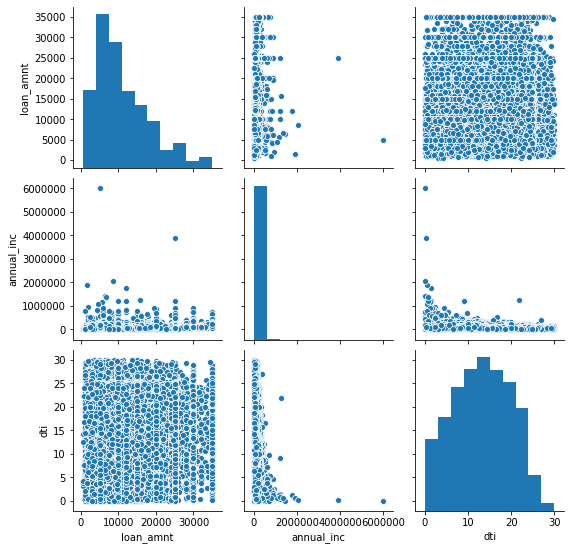

In [16]:
# Pair Plot
sns.pairplot(loan)

- Distirbution of DTI looks like normal distribution, which is analyzed further in the next section below

### Segmented Univariate Analysis

#### Impact of following on Loan Repayment Status
1. **DTI**
2. **Loan Amount**
3. **Annual Income**
4. **Home Ownership**
5. **Loan Sub Grade**
6. **Employment Length**
7. **Loan Purpose**
8. **Loan Term**
9. **State**
10. **Verification Status**
<br>

Get the borrower details of charge-off and fully paid loans into seperate dataframes

In [17]:
# Fully Paid Loans
paid = loan.loc[loan['loan_status'] == 'Fully Paid']
paid.describe().round(2)[['loan_amnt','annual_inc','dti']]

,loan_amnt,annual_inc,dti
count,32950.00,32950.00,32950.00
mean,10866.46,69862.50,13.15
std,7199.63,66562.25,6.68
min,500.00,4000.00,0.00
25%,5200.00,41132.75,7.98
50%,9600.00,60000.00,13.20
75%,15000.00,84000.00,18.39
max,35000.00,6000000.00,29.99


In [18]:
# Charged off Loans
choff = loan.loc[loan['loan_status'] == 'Charged Off']
choff.describe().round(2)[['loan_amnt','annual_inc','dti']]

,loan_amnt,annual_inc,dti
count,5627.00,5627.00,5627.00
mean,12104.39,62427.30,14.00
std,8085.73,47776.01,6.59
min,900.00,4080.00,0.00
25%,5600.00,37000.00,9.05
50%,10000.00,53000.00,14.29
75%,16500.00,75000.00,19.29
max,35000.00,1250000.00,29.85


1. `DTI:`

- Check that DTI is normally distributed as the mean and median values are very close to each other
- Perform **Critical Value Method** to understand the values above which borrower tends to default the loan

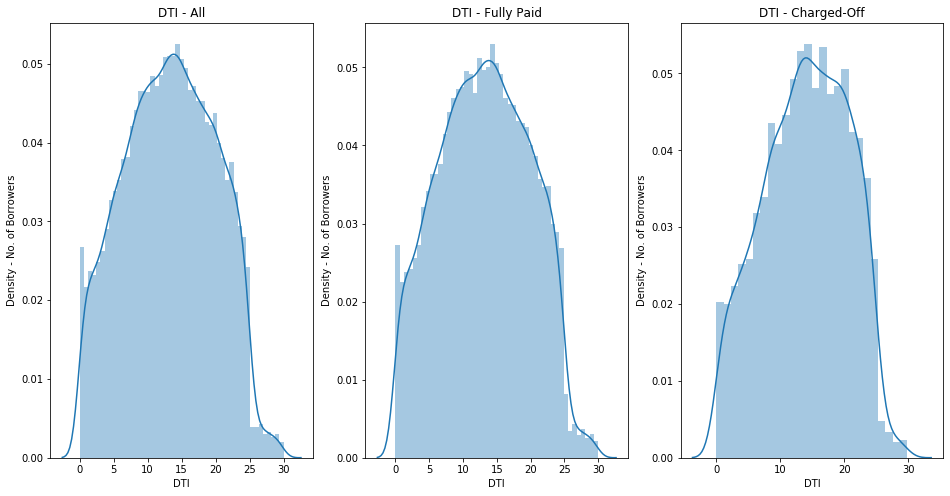

In [19]:
# Check if DTI is normally distributed
# As the mean and median values are very close to each other, DTI is very likely to be normally distributed

# histogram plot
# adjust figure size 
plt.figure(figsize = (16, 8))

# Plot the DTI of all the loans
plt.subplot(1, 3, 1)
sns.distplot(loan['dti'])
plt.title("DTI - All")
plt.xlabel("DTI")
plt.ylabel("Density - No. of Borrowers")

# Plot the DTI of Fully Paid Loans
plt.subplot(1, 3, 2)
sns.distplot(paid['dti'])
plt.title("DTI - Fully Paid")
plt.xlabel("DTI")
plt.ylabel("Density - No. of Borrowers")

# Plot the DTI of Charged-off loans
plt.subplot(1, 3, 3)
sns.distplot(choff['dti'])
plt.title("DTI - Charged-Off")
plt.xlabel("DTI")
plt.ylabel("Density - No. of Borrowers")

plt.show()

Perform Critical Value Method on **DTI** to find out which value falls in critical region for the significance level of 5%:

In [20]:
# From the plots above, DTI appears normally distributed

# Perform Critical Value Method to find out which value falls in critical region for significance level of 5% and
# determine beyond which threshold of DTI, a borrower is likely to default

# Null Hypotheses Ho: If DTI <= DTI_mean (13.15) for fully paid then borrowers are more likely to pay off the loan.
# As it is a right-tailed test, Calculate the UCV
fully_paid_UCV = round((np.mean(paid['dti'] + (np.std(paid['dti'])/np.sqrt(paid.shape[0]))*stats.norm.ppf(.95))),2)

print("The upper critical value for Fully Paid normal curve: ", fully_paid_UCV)
print("Borrower is likely to fully pay if the DTI is below {} considering 5% alpha (i.e. 0.05)".format(fully_paid_UCV))

# Perform Critical value method to find out which value falls in critical region for significance level of 5% and
# determine below which threshold of DTI, a borrower is likely to fully pay the loan

# Null Hypotheses Ho: If DTI >= DTI_mean (14.00) for Charged off then borrowers are more likely to default.
# As it is a left-tailed test, Calculate the LCV
# (Even for LCV, mean is added with z-score instead of subtraction as value of z-score for 0.05 is negative)
choff_LCV = round((np.mean(choff['dti'] + (np.std(choff['dti'])/np.sqrt(choff.shape[0]))*stats.norm.ppf(.05))),2)

print("The lower critical value for charged off normal curve: ", choff_LCV)
print("Borrower is likely to default if the DTI is above {} considering 5% alpha (i.e. 0.05)".format(choff_LCV))

The upper critical value for Fully Paid normal curve:  13.21
Borrower is likely to fully pay if the DTI is below 13.21 considering 5% alpha (i.e. 0.05)
The lower critical value for charged off normal curve:  13.86
Borrower is likely to default if the DTI is above 13.86 considering 5% alpha (i.e. 0.05)


From the result above, it is clear that at DTI of 13.21, we reach very close to the critical region (for the significance level of 5%) of the Fully Paid loans and at DTI of 13.86, we reach very close to the critical region (for the significance level of 5%) of the Charged-Off loans.<br>
So 
- DTI < 13.21 means that the borrower is more likely to fully repay the loan and 
- DTI > 13.86 means that the borrower is more likely to default the loan

2. `Loan Amount:`

- Group the Loan Amount into bins to see the pattern of loan default or pay status
- Create bins for the annual income
- Plot the values to analyze the pattern

In [21]:
# Analysis of Impact of Loan Amount on Loan Repayment Status:

# Create bins for the loan amount
loan_amnt_bins = [0, 5000, 10000, 15000, 20000, 25000, 30000, 35000]
# Create label for every bin created -> Q1 to Q4 signifying each level of loan amount
loan_amnt_labels = ['0-5000', '5000-10000', '10000-15000', '15000-20000', '20000-25000','25000-30000', '30000-35000']

# Get loan amount and loan_status in a seperate dataframe
loan_amnt_ls = loan.loc[:,['loan_amnt', 'loan_status']]

# Add the loan amount level labels to the dataframe and get the count of it in each loan status type
loan_amnt_ls['loan_level'] = pd.cut(loan_amnt_ls.loan_amnt, bins=loan_amnt_bins, labels =loan_amnt_labels)
loan_amnt_ls = loan_amnt_ls.loc[:, ['loan_level','loan_status']]
loan_amnt_ls = loan_amnt_ls.groupby(['loan_level', 'loan_status']).size()
loan_amnt_ls

loan_level   loan_status
0-5000       Charged Off    1314 
             Fully Paid     8158 
5000-10000   Charged Off    1642 
             Fully Paid     11160
10000-15000  Charged Off    1055 
             Fully Paid     6628 
15000-20000  Charged Off    751  
             Fully Paid     3598 
20000-25000  Charged Off    542  
             Fully Paid     2294 
25000-30000  Charged Off    143  
             Fully Paid     557  
30000-35000  Charged Off    180  
             Fully Paid     555  
dtype: int64

In [22]:
# Get the count of entries (sum of fully paid count and charged off loan count)
la_gl = []
for i in loan_amnt_ls.reset_index().groupby('loan_level').sum()[0]:
    la_gl.append(i)
    la_gl.append(i)
la_gl

# Get percentage of each loan type in each loan amount level
amnt_pcnt = round(100*(loan_amnt_ls)/la_gl, 2).reset_index()
amnt_pcnt['percent'] = amnt_pcnt[0]
amnt_pcnt = amnt_pcnt.drop(0, axis=1)
amnt_pcnt

,loan_level,loan_status,percent
0,0-5000,Charged Off,13.87
1,0-5000,Fully Paid,86.13
2,5000-10000,Charged Off,12.83
3,5000-10000,Fully Paid,87.17
4,10000-15000,Charged Off,13.73
5,10000-15000,Fully Paid,86.27
6,15000-20000,Charged Off,17.27
7,15000-20000,Fully Paid,82.73
8,20000-25000,Charged Off,19.11
9,20000-25000,Fully Paid,80.89


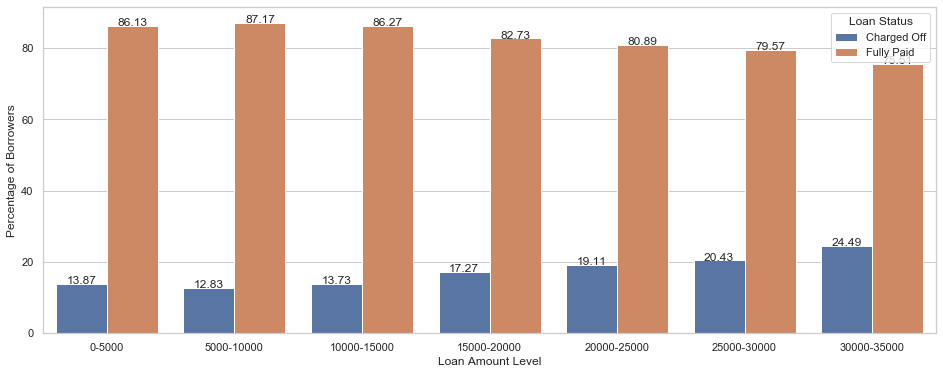

In [23]:
# Plot the loan status vs loan amount to understand the pattern

# set the seaborn theme
sns.set(style = "whitegrid")
# adjust figure size 
plt.figure(figsize=(16,6))

# Draw the Plot
ax = sns.barplot(y='percent', x='loan_level', hue='loan_status', data=amnt_pcnt)
# Get values of each bar
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2., height, '{:1.2f}'.format(height), ha="center") 
    
plt.xlabel("Loan Amount Level")
plt.ylabel("Percentage of Borrowers")
plt.legend(title = "Loan Status")

plt.show()

From the chart above, following inferences can be made:
- Borrowers with loan amount > 15,000 USD tend to default, those with < 15,000 USD tend to pay

3. `Annual Income:`

- Group the Annual Income into bins to see the pattern of loan default or pay status
- Create bins for every 10th percentile of the annual income
- Also add one very low income (4,000 USD) and one one very high income (6,000,000 USD)
- Plot the values to analyze the pattern

In [24]:
# Analysis of Impact of Annual Income on Loan Repayment Status:

# Create bins for every 10th percentile of the annual income
# Also add one very low income (4,000 USD) and one one very high income (6,000,000 USD)
annual_inc_bins = list(loan.annual_inc.quantile([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.99]))
annual_inc_bins.append(6000000)
annual_inc_bins.insert(0,4000)

# Create label for every bin created -> L1 to L11 signifying each level of income
annual_inc_labels = []
for i in range(1, 12):
    annual_inc_labels.append('L'+str(i))

# Get annual income and loan_status in a seperate dataframe
annual_inc_ls = loan.loc[:,['annual_inc', 'loan_status']]

# Add the income level labels to the dataframe and get the count of it in each loan status type
annual_inc_ls['inc_level'] = pd.cut(annual_inc_ls.annual_inc, bins = annual_inc_bins, labels =annual_inc_labels)
annual_inc_ls = annual_inc_ls.loc[:, ['inc_level','loan_status']]
annual_inc_ls = annual_inc_ls.groupby(['inc_level', 'loan_status']).size()
annual_inc_ls

inc_level  loan_status
L1         Charged Off    839 
           Fully Paid     3711
L2         Charged Off    574 
           Fully Paid     2591
L3         Charged Off    627 
           Fully Paid     3232
L4         Charged Off    592 
           Fully Paid     3317
L5         Charged Off    561 
           Fully Paid     3244
L6         Charged Off    588 
           Fully Paid     3286
L7         Charged Off    518 
           Fully Paid     3376
L8         Charged Off    510 
           Fully Paid     3525
L9         Charged Off    389 
           Fully Paid     3242
L10        Charged Off    386 
           Fully Paid     3082
L11        Charged Off    43  
           Fully Paid     343 
dtype: int64

In [25]:
# Get the count of entries (sum of fully paid count and charged off loan count)
ai_gl = []
for i in annual_inc_ls.reset_index().groupby('inc_level').sum()[0]:
    ai_gl.append(i)
    ai_gl.append(i)
ai_gl

# Get percentage of each loan type in each income level
inc_pcnt = round(100*(annual_inc_ls)/ai_gl, 2).reset_index()
inc_pcnt['percent'] = inc_pcnt[0]
inc_pcnt = inc_pcnt.drop(0, axis=1)
inc_pcnt

,inc_level,loan_status,percent
0,L1,Charged Off,18.44
1,L1,Fully Paid,81.56
2,L2,Charged Off,18.14
3,L2,Fully Paid,81.86
4,L3,Charged Off,16.25
5,L3,Fully Paid,83.75
6,L4,Charged Off,15.14
7,L4,Fully Paid,84.86
8,L5,Charged Off,14.74
9,L5,Fully Paid,85.26


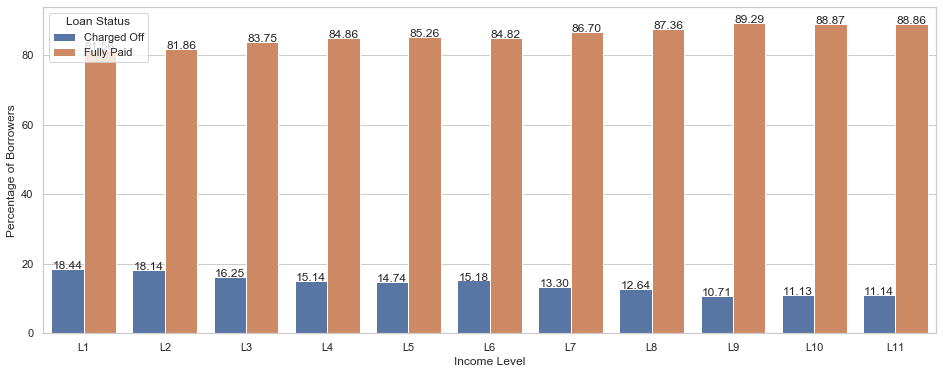

In [26]:
# Plot the loan status vs Income Level to understand the pattern

# set the seaborn theme
sns.set(style = "whitegrid")
# adjust figure size 
plt.figure(figsize=(16,6))

# Draw the Plot
ax = sns.barplot(y='percent', x='inc_level', hue='loan_status', data=inc_pcnt)
# Get values of each bar
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2., height, '{:1.2f}'.format(height), ha="center") 
    
plt.xlabel("Income Level")
plt.ylabel("Percentage of Borrowers")
plt.legend(title = "Loan Status")

plt.show()

From the chart above, following inferences can be made:
- Borrowers with annual income < 55,000 USD (L5 Level) tend to default and those with > 65,000 USD (L6 income level) tend to pay

4. `Home Ownership:`

In [27]:
# Seeing the effect of Home Ownership on Loan Repayment Status

# Remove the rows with home ownership as None as they are very few in number (3 to be exact)
loan_home = loan.loc[loan['home_ownership'] != 'NONE']
loan_home['home_ownership'] = loan_home['home_ownership'].cat.remove_unused_categories()

# Get percentage of Loan Status in each of the home ownership type
home_own_count = loan_home.pivot_table(index = 'home_ownership', values = 'loan_status', aggfunc = {'home_ownership': 'count'})    
loan_status_home_count = loan_home.pivot_table(index = ['home_ownership', 'loan_status'], aggfunc = {'home_ownership': 'count'})
loan_status_home_pcnt = round(loan_status_home_count * 100 / home_own_count, 2)

# Select top categories which have Fully Paid
top_paid = list(loan_status_home_pcnt.iloc[np.arange(1, len(loan_status_home_pcnt), 2),0])
top_paid.sort(reverse = True)

# Select top categories which have resulted in Charged-Off
top_choff = list(loan_status_home_pcnt.iloc[np.arange(0, len(loan_status_home_pcnt), 2),0])
top_choff.sort(reverse = True)

# Highlight large deviaitons
def highlighter_top2(val): 
    # Highlight the top 2 worst affecting charge-off cases
    if val in top_choff[0:2]:
        color = 'orangered'
    # Highlight the top 2 best fully paid cases
    elif val in top_paid[0:2]:
        color = 'springgreen'
    else:
        color = 'white'
    return 'background: %s' % color

loan_status_home_pcnt_sty = loan_status_home_pcnt.style.applymap(highlighter_top2).format({'home_ownership':'{0:,.2f}%'})
loan_status_home_pcnt_sty

From the above table, following inferences can be made:
- Borrowers with Rented Houses or Other as Home Ownership status tend do Default more than others
- Borrowers with Mortgaged House or living in Own Hosue tend to pay off the loan more than others

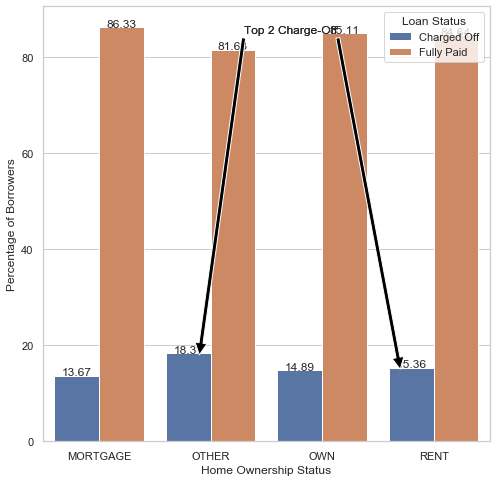

In [28]:
# Plot the above table in a chart

# Reorganize the dataframe so that it can be plotted
loan_status_home_pcnt.rename({'home_ownership':'home'}, axis='columns', inplace = True)
loan_status_home_pcnt.reset_index(inplace = True)

# histogram plot
# set the seaborn theme
sns.set(style = "whitegrid")
# adjust figure size 
plt.figure(figsize = (8, 8))

home_graph = sns.barplot(x = 'home_ownership', y = 'home', hue = 'loan_status', data = loan_status_home_pcnt)
plt.xlabel("Home Ownership Status")
plt.ylabel("Percentage of Borrowers")
plt.legend(title = "Loan Status")
# Get values of each bar
for p in home_graph.patches:
    height = p.get_height()
    home_graph.text(p.get_x()+p.get_width()/2., height, '{:1.2f}'.format(height), ha="center") 
# Highlight the Top 2 Charge-Off types
home_graph.annotate('Top 2 Charge-Off', xy = (0.90, 18), xytext = (1.3, 85),
                    arrowprops = dict(facecolor = 'black', shrink = 1))
home_graph.annotate('Top 2 Charge-Off', xy = (2.70, 15), xytext = (1.3, 85),
                    arrowprops = dict(facecolor = 'black', shrink = 1))

plt.show()

5. `Loan Sub-Grade:`

In [29]:
# Seeing the effect of Loan Sub-grade on Loan Repayment Status

# Get percentage of Loan Status in each of the loan sub-grade type
sub_grade_count = loan.pivot_table(index = 'sub_grade', values = 'loan_status', aggfunc = {'sub_grade': 'count'})    
loan_status_grade_count = loan.pivot_table(index = ['sub_grade', 'loan_status'], aggfunc = {'sub_grade': 'count'})
loan_status_grade_pcnt = round(loan_status_grade_count * 100 / sub_grade_count, 2)

loan_status_grade_pcnt.unstack().style.background_gradient(cmap='Blues').format('{0:,.2f}%')

From the above table, following inferences can be made:
- Borrowers who have taken loan with Grade beyond D2 tend do Default more than others
- Borrowers who have taken loan with Grade A or B tend to pay off the loan more than others

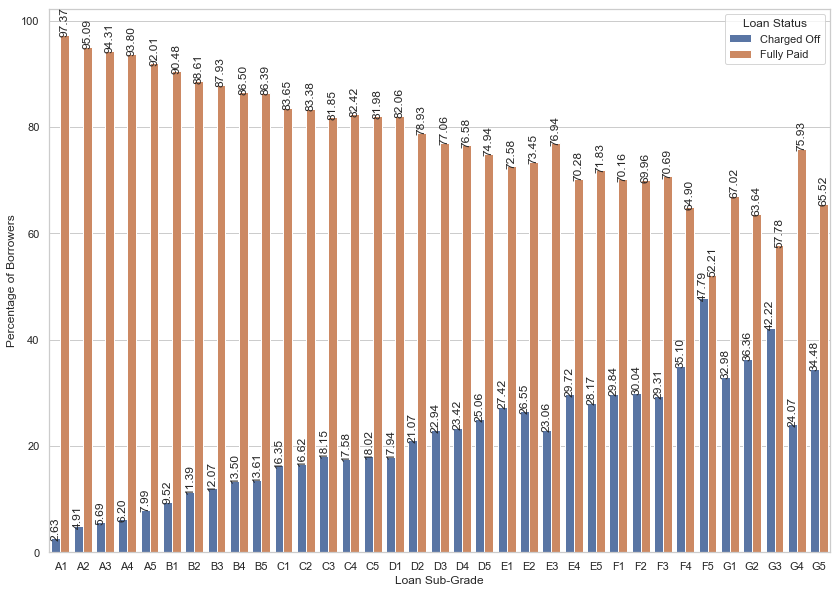

In [30]:
# Plot the above table in a chart

# Reorganize the dataframe so that it can be plotted
loan_status_grade_pcnt.rename({'sub_grade':'grade'}, axis='columns', inplace = True)
loan_status_grade_pcnt.reset_index(inplace = True)

# histogram plot
# set the seaborn theme
sns.set(style = "whitegrid")
# adjust figure size 
plt.figure(figsize = (14, 10))

grade_graph = sns.barplot(x = 'sub_grade', y = 'grade', hue = 'loan_status', data = loan_status_grade_pcnt)
plt.xlabel("Loan Sub-Grade")
plt.ylabel("Percentage of Borrowers")
plt.legend(title = "Loan Status")
# Get values of each bar
for p in grade_graph.patches:
    height = p.get_height()
    grade_graph.text(p.get_x()+p.get_width()/2., height, '{:1.2f}'.format(height), ha="center", rotation = 90) 

plt.show()

6. `Employment Length:`

In [31]:
# Seeing the effect of Employment Length on Loan Repayment Status

# Get percentage of Loan Status in each of the Employment Length type
emp_length_count = loan.pivot_table(index = 'emp_length', values = 'loan_status', aggfunc = {'emp_length': 'count'})    
loan_status_emp_count = loan.pivot_table(index = ['emp_length', 'loan_status'], aggfunc = {'emp_length': 'count'})
loan_status_emp_pcnt = loan_status_emp_count * 100 / emp_length_count

# Select top categories which have Fully Paid
top_paid = list(loan_status_emp_pcnt.iloc[np.arange(1, len(loan_status_emp_pcnt), 2),0])
top_paid.sort(reverse = True)

# Select top categories which have resulted in Charged-Off
top_choff = list(loan_status_emp_pcnt.iloc[np.arange(0, len(loan_status_emp_pcnt), 2),0])
top_choff.sort(reverse = True)

loan_status_emp_pcnt_sty = loan_status_emp_pcnt.style.applymap(highlighter_top2).format({'emp_length':'{0:,.2f}%'})

loan_status_emp_pcnt_sty

From the table above, borrowers with 9 years experience tend to Fully pay the loans but with 10+ years experience tend to default! Also, Borrowers with experience not filled tend to Default the loans

- Hence we can conclude that Employment Length cannot be considered as a driving factor behind loan default. So it is not considered

7. `Loan Purpose:`

In [32]:
# Seeing the effect of Loan Purpose on Loan Repayment Status

# Get percentage of Loan Status in each of the Loan Purpose
purpose_count = loan.pivot_table(index = 'purpose', values = 'loan_status', aggfunc = {'purpose': 'count'})    
loan_status_purp_count = loan.pivot_table(index = ['purpose', 'loan_status'], aggfunc = {'purpose': 'count'})
loan_status_purp_pcnt = loan_status_purp_count * 100 / purpose_count

# Select top categories which have Fully Paid
top_paid = list(loan_status_purp_pcnt.iloc[np.arange(1, len(loan_status_purp_pcnt), 2),0])
top_paid.sort(reverse = True)

# Select top categories which have resulted in Charged-Off
top_choff = list(loan_status_purp_pcnt.iloc[np.arange(0, len(loan_status_purp_pcnt), 2),0])
top_choff.sort(reverse = True)

loan_status_purp_pcnt_sty = loan_status_purp_pcnt.style.applymap(highlighter_top2).format({'purpose':'{0:,.2f}%'})
loan_status_purp_pcnt_sty

From the table above, following inferences can be made:
- Borrowers who bought the loan for small business purpose tend to default the highest
- Borrowers who bought the loan for renewable energy purpose tend to default more
- Borrowers who bought the loan for major purchase and wedding purposes tend to fully pay the loan more

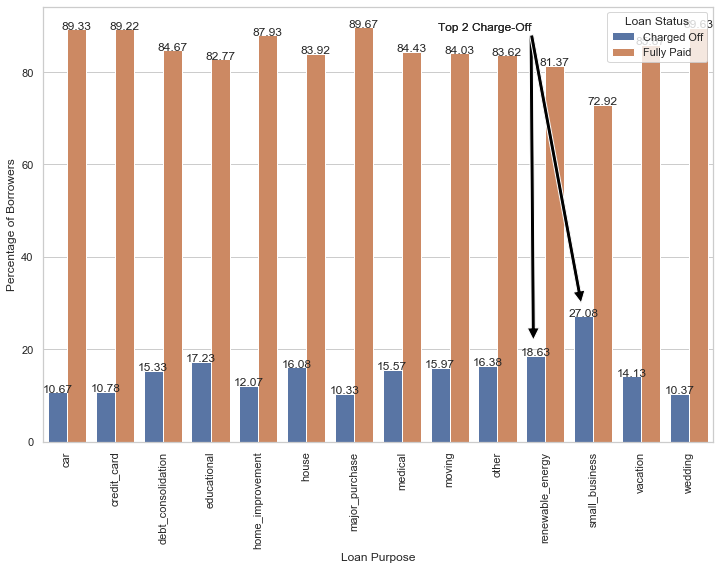

In [33]:
# Plot the above table in a chart

# Reorganize the dataframe so that it can be plotted
loan_status_purp_pcnt.rename({'purpose':'purp'}, axis='columns', inplace = True)
loan_status_purp_pcnt.reset_index(inplace = True)

# histogram plot
# set the seaborn theme
sns.set(style = "whitegrid")
# adjust figure size 
plt.figure(figsize = (12, 8))

purp_graph = sns.barplot(x = 'purpose', y = 'purp', hue = 'loan_status', data = loan_status_purp_pcnt)
plt.xlabel("Loan Purpose")
plt.ylabel("Percentage of Borrowers")
plt.legend(title = "Loan Status")
plt.xticks(rotation = 90)
# Get values of each bar
for p in purp_graph.patches:
    height = p.get_height()
    purp_graph.text(p.get_x()+p.get_width()/2., height, '{:1.2f}'.format(height), ha="center") 
# Highlight the Top 2 Charge-Off types
purp_graph.annotate('Top 2 Charge-Off', xy = (9.75, 22), xytext = (7.75, 89),
                    arrowprops = dict(facecolor = 'black', shrink = 1))
purp_graph.annotate('Top 2 Charge-Off', xy = (10.75, 30), xytext = (7.75, 89),
                    arrowprops = dict(facecolor = 'black', shrink = 1))


plt.show()

8. `Loan Term:`

In [34]:
# Seeing the effect of Loan Term on Loan Repayment Status

# Get percentage of Loan Status in each of the Loan Term
term_count = loan.pivot_table(index = 'term', values = 'loan_status', aggfunc = {'term': 'count'})    
loan_status_term_count = loan.pivot_table(index = ['term', 'loan_status'], aggfunc = {'term': 'count'})
loan_status_term_pcnt = loan_status_term_count * 100 / term_count

# Select top category which has Fully Paid
top_paid = max(loan_status_term_pcnt.iloc[np.arange(1, len(loan_status_term_pcnt), 2),0])

# Select top category which has resulted in Charged-Off
top_choff = max(loan_status_term_pcnt.iloc[np.arange(0, len(loan_status_term_pcnt), 2),0])

# Highlight large deviaitons
def highlighter_top(val): 
    # Highlight the top worst affecting charge-off case
    if val == top_choff:
        color = 'orangered'
    # Highlight the top best fully paid case
    elif val == top_paid:
        color = 'springgreen'
    else:
        color = 'white'
    return 'background: %s' % color

loan_status_term_pcnt_sty = loan_status_term_pcnt.style.applymap(highlighter_top).format({'term':'{0:,.2f}%'})
loan_status_term_pcnt_sty

From the table above, following inferences can be made:

- Borrowers who have taken the loan for 5 years are likely to default the loan (more likely)
- Borrowers who have taken the loan for 3 years are likely to fully pay the loan

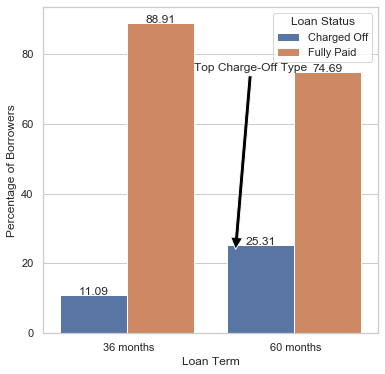

In [35]:
# Plot the above table in a chart

# Reorganize the dataframe so that it can be plotted
loan_status_term_pcnt.rename({'term':'trm'}, axis='columns', inplace = True)
loan_status_term_pcnt.reset_index(inplace = True)

# histogram plot
# set the seaborn theme
sns.set(style = "whitegrid")
# adjust figure size 
plt.figure(figsize = (6, 6))

term_graph = sns.barplot(x = 'term', y = 'trm', hue = 'loan_status', data = loan_status_term_pcnt)
plt.xlabel("Loan Term")
plt.ylabel("Percentage of Borrowers")
plt.legend(title = "Loan Status")
# Get values of each bar
for p in term_graph.patches:
    height = p.get_height()
    term_graph.text(p.get_x()+p.get_width()/2., height, '{:1.2f}'.format(height), ha="center") 
# Highlight the Top Charge-Off type
term_graph.annotate('Top Charge-Off Type', xy = (0.65, 24), xytext = (0.4, 75),
                    arrowprops = dict(facecolor = 'black', shrink = 1))


plt.show()

9. `State:`

In [36]:
# Seeing the effect of State on Loan Repayment Status

# Get only those states which have atleast 30 borrowers
state_30 = (loan['addr_state'].value_counts() > 30)
state_30 = state_30.loc[state_30 == True].index
loan_state = loan.loc[loan['addr_state'].isin(state_30)]
loan_state['addr_state'] = loan_state['addr_state'].cat.remove_unused_categories()

# Get percentage of Loan Status in each of the State
addr_state_count = loan_state.pivot_table(index = 'addr_state', values = 'loan_status', aggfunc = {'addr_state': 'count'})    
loan_status_state_count = loan_state.pivot_table(index = ['addr_state', 'loan_status'], aggfunc = {'addr_state': 'count'})
loan_status_state_pcnt = loan_status_state_count * 100 / addr_state_count

# Select top categories which have Fully Paid
top_paid = list(loan_status_state_pcnt.iloc[np.arange(1, len(loan_status_state_pcnt), 2),0])
top_paid.sort(reverse = True)

# Select top categories which have resulted in Charged-Off
top_choff = list(loan_status_state_pcnt.iloc[np.arange(0, len(loan_status_state_pcnt), 2),0])
top_choff.sort(reverse = True)

loan_status_state_pcnt_sty = loan_status_state_pcnt.style.applymap(highlighter_top2).format({'addr_state':'{0:,.2f}%'})
loan_status_state_pcnt_sty

From the table above, following inferences can be made:

- Borrowers from the states Nevada and South Dakota are likely to default the loan
- Borrowers from the states Washington D.C. and Wyoming are likely to fully pay the loan

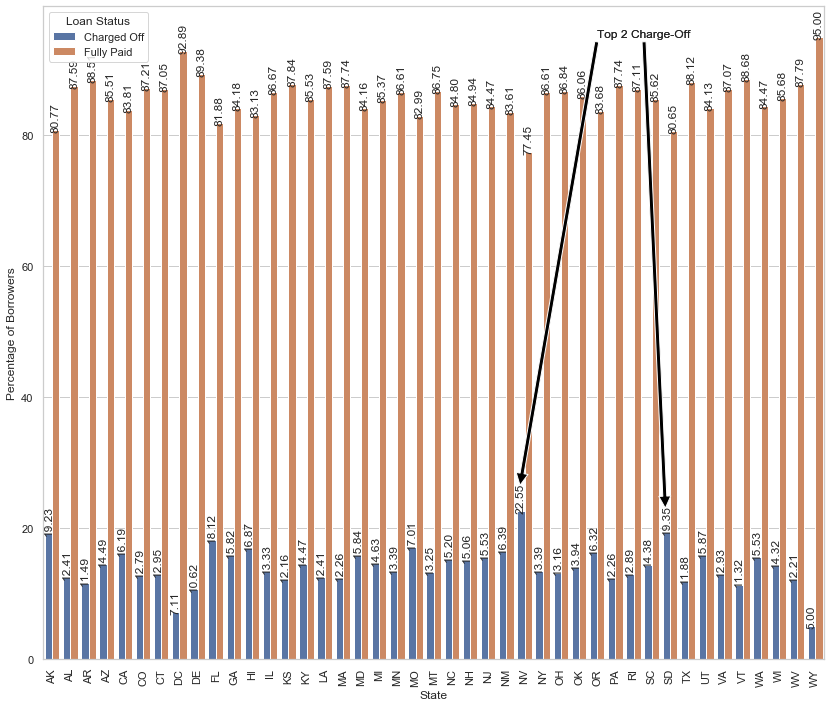

In [37]:
# Plot the above table in a chart

# Reorganize the dataframe so that it can be plotted
loan_status_state_pcnt.rename({'addr_state':'state'}, axis='columns', inplace = True)
loan_status_state_pcnt.reset_index(inplace = True)

# histogram plot
# set the seaborn theme
sns.set(style = "whitegrid")
# adjust figure size 
plt.figure(figsize = (14, 12))

state_graph = sns.barplot(x = 'addr_state', y = 'state', hue = 'loan_status', data = loan_status_state_pcnt)
plt.xlabel("State")
plt.ylabel("Percentage of Borrowers")
plt.legend(title = "Loan Status")
plt.xticks(rotation = 90)
# Get values of each bar
for p in state_graph.patches:
    height = p.get_height()
    state_graph.text(p.get_x()+p.get_width()/2., height, '{:1.2f}'.format(height), ha="center", rotation = 90) 
# Highlight the Top 2 Charge-Off types
state_graph.annotate('Top 2 Charge-Off', xy = (25.75, 26.5), xytext = (30, 95),
                    arrowprops = dict(facecolor = 'black', shrink = 1))
state_graph.annotate('Top 2 Charge-Off', xy = (33.75, 23), xytext = (30, 95),
                    arrowprops = dict(facecolor = 'black', shrink = 1))

plt.show()

10. `Verification Status:`

In [38]:
# Seeing the effect of Verification Status on Loan Repayment Status

# Get percentage of Loan Status in each of the Verification Status
verfn_count = loan.pivot_table(index = 'verification_status', values = 'loan_status', aggfunc = {'verification_status': 'count'})    
loan_status_verfn_count = loan.pivot_table(index = ['verification_status', 'loan_status'], aggfunc = {'verification_status': 'count'})
loan_status_verfn_pcnt = loan_status_verfn_count * 100 / verfn_count

# Select top category which has Fully Paid
top_paid = max(loan_status_verfn_pcnt.iloc[np.arange(1, len(loan_status_verfn_pcnt), 2),0])

# Select top category which has resulted in Charged-Off
top_choff = max(loan_status_verfn_pcnt.iloc[np.arange(0, len(loan_status_verfn_pcnt), 2),0])

loan_status_verfn_pcnt_sty = loan_status_verfn_pcnt.style.applymap(highlighter_top).format({'verification_status':'{0:,.2f}%'})
loan_status_verfn_pcnt_sty

Usually trustworthy borrowers are not really verified by the Lending Club. Those whose details are verified are the borrowers who have lesser credit track record. Details are available in this link: https://www.lendingclub.com/investing/investor-education/income-verification <br>
From the table above, following inference can be made:
- So the result is as expected: Verified Borrowers tend to default more than Not Verified Borrowers

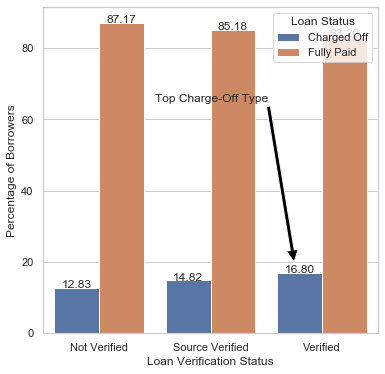

In [39]:
# Plot the above table in a chart

# Reorganize the dataframe so that it can be plotted
loan_status_verfn_pcnt.rename({'verification_status':'verfn'}, axis='columns', inplace = True)
loan_status_verfn_pcnt.reset_index(inplace = True)

# histogram plot
# set the seaborn theme
sns.set(style = "whitegrid")
# adjust figure size 
plt.figure(figsize = (6, 6))

term_graph = sns.barplot(x = 'verification_status', y = 'verfn', hue = 'loan_status', data = loan_status_verfn_pcnt)
plt.xlabel("Loan Verification Status")
plt.ylabel("Percentage of Borrowers")
plt.legend(title = "Loan Status")
# Get values of each bar
for p in term_graph.patches:
    height = p.get_height()
    term_graph.text(p.get_x()+p.get_width()/2., height, '{:1.2f}'.format(height), ha="center") 
# Highlight the Top Charge-Off type
term_graph.annotate('Top Charge-Off Type', xy = (1.75, 20), xytext = (0.5, 65),
                    arrowprops = dict(facecolor = 'black', shrink = 1))


plt.show()

### Bivariate Analysis

#### Impact of following on Loan Repayment Status
1. **Loan Amount and Annual Income**
2. **Loan Term and Loan Purpose**
3. **Loan Term and Employment Length on Loan Status**
4. **Loan Term and Verification Status on Loan Status**
5. **Home Ownership and Annual Income**
6. **Loan Amount and Others on Loan Status**
<br>

1. `Loan Amount and Annual Income on Loan Status:`

- Check if there is a good correlation between loan amount and annual income in loan default cases

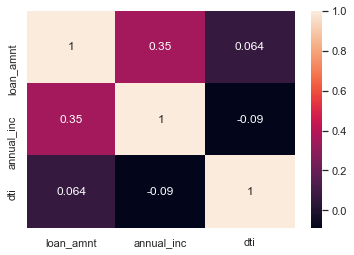

In [40]:
# Seeing the effect of Loan Amount and Annual Income on Loan Repayment Status

# Draw correlation heatmap of loan default cases to check pattern
sns.heatmap(choff.corr(), annot = True)

- The heatmap says there is less correlation (0.35) between Loan Amount and Annual Income in case of default loans
- Hence, no relationship exists between loan default with annual income and loan amount 

2. `Loan Term and Loan Purpose on Loan Status:`

In [41]:
# Seeing the effect of Loan Term and Purpose on Loan Repayment Status

# Get percentage of Loan Status in each of the Loan Purpose in Loan Term
term_purpose_count = loan.pivot_table(index = ['term', 'purpose'], values = 'loan_status', aggfunc = {'purpose': 'count'})  
loan_status_term_purp_count = loan.pivot_table(index = ['term','purpose', 'loan_status'], aggfunc = {'purpose': 'count'})
loan_status_term_purp_pcnt = loan_status_term_purp_count * 100 / term_purpose_count

# Select top categories which have Fully Paid in each loan term
top_paid = []
# Top categories of 36 months loan term
top_paid_36 = list(loan_status_term_purp_pcnt.iloc[np.arange(1, len(loan_status_term_purp_pcnt)/2, 2),0])
# Top categories of 60 months loan term
top_paid_60 = list(loan_status_term_purp_pcnt.iloc[np.arange(len(loan_status_term_purp_pcnt)/2+1, len(loan_status_term_purp_pcnt), 2),0])
# Get both together
top_paid = sorted(top_paid_36, reverse = True)[0:2]
top_paid += sorted(top_paid_60, reverse = True)[0:2]

# Select top categories which have resulted in Charged-Off in each loan term
top_choff = []
# Top categories of 36 months loan term
top_choff_36 = list(loan_status_term_purp_pcnt.iloc[np.arange(0, len(loan_status_term_purp_pcnt)/2, 2),0])
# Top categories of 60 months loan term
top_choff_60 = list(loan_status_term_purp_pcnt.iloc[np.arange(len(loan_status_term_purp_pcnt)/2, len(loan_status_term_purp_pcnt), 2),0])
# Get both together
top_choff = sorted(top_choff_36, reverse = True)[0:2]
top_choff += sorted(top_choff_60, reverse = True)[0:2]

# Highlight large deviaitons
def highlighter_top4(val): 
    # Highlight the top 2 worst affecting charge-off cases
    if val in top_choff:
        color = 'orangered'
    # Highlight the top 2 best fully paid cases
    elif val in top_paid:
        color = 'springgreen'
    else:
        color = 'white'
    return 'background: %s' % color

loan_status_term_purp_pcnt_sty = loan_status_term_purp_pcnt.style.applymap(highlighter_top4).format({'purpose':'{0:,.2f}%'})
loan_status_term_purp_pcnt_sty

From the table above, following inferences can be made:

- Borrowers who have taken loan for the purpose renewable energy and small business with 36 months tenure are more likely to default
- Borrowers who have taken loan for the purpose educational and small business with 60 months tenure are more likely to default

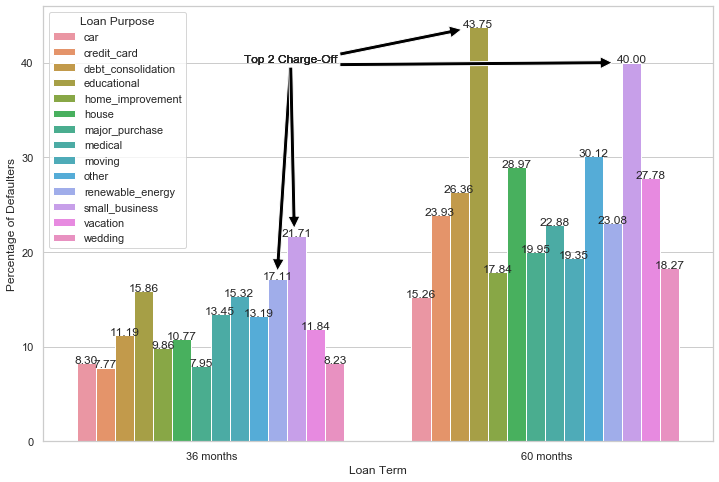

In [42]:
# Plot the above table in a chart

# Reorganize the dataframe so that it can be plotted
loan_status_term_purp_pcnt.rename({'purpose':'purp'}, axis='columns', inplace = True)
loan_status_term_purp_pcnt.reset_index(inplace = True)
loan_status_term_purp_pcnt = loan_status_term_purp_pcnt.loc[loan_status_term_purp_pcnt['loan_status'] == 'Charged Off']

# histogram plot
# set the seaborn theme
sns.set(style = "whitegrid")
# adjust figure size 
plt.figure(figsize = (12, 8))

purp_graph = sns.barplot(x = 'term', y = 'purp', hue = 'purpose', data = loan_status_term_purp_pcnt)
plt.xlabel("Loan Term")
plt.ylabel("Percentage of Defaulters")
plt.legend(title = "Loan Purpose")
# Get values of each bar
for p in purp_graph.patches:
    height = p.get_height()
    purp_graph.text(p.get_x()+p.get_width()/2., height, '{:1.2f}'.format(height), ha="center") 
# Highlight the Top 2 Charge-Off types
purp_graph.annotate('Top 2 Charge-Off', xy = (0.2, 18), xytext = (0.1, 40),
                    arrowprops = dict(facecolor = 'black', shrink = 1))
purp_graph.annotate('Top 2 Charge-Off', xy = (0.25, 22.5), xytext = (0.1, 40),
                    arrowprops = dict(facecolor = 'black', shrink = 1))
purp_graph.annotate('Top 2 Charge-Off', xy = (0.75, 43.5), xytext = (0.1, 40),
                    arrowprops = dict(facecolor = 'black', shrink = 1))
purp_graph.annotate('Top 2 Charge-Off', xy = (1.2, 40), xytext = (0.1, 40),
                    arrowprops = dict(facecolor = 'black', shrink = 1))

plt.show()

3. `Loan Term and Employment Length on Loan Status:`

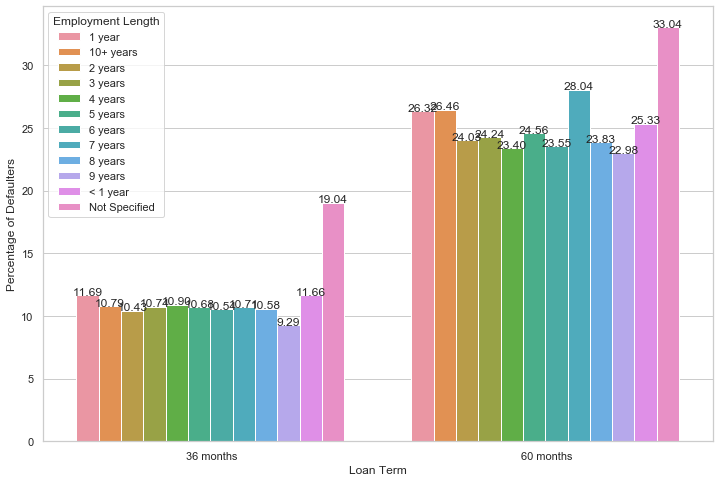

In [43]:
# Seeing the effect of Loan Term and Employment Length on Loan Repayment Status

# Get percentage of Loan Status in each of the Employment Length in Loan Term
term_emp_count = loan.pivot_table(index = ['term', 'emp_length'], values = 'loan_status', aggfunc = {'emp_length': 'count'})  
loan_status_term_emp_count = loan.pivot_table(index = ['term','emp_length', 'loan_status'], aggfunc = {'emp_length': 'count'})
loan_status_term_emp_pcnt = loan_status_term_emp_count * 100 / term_emp_count

# Plot the table in a chart

# Reorganize the dataframe so that it can be plotted
loan_status_term_emp_pcnt.rename({'emp_length':'empl'}, axis='columns', inplace = True)
loan_status_term_emp_pcnt.reset_index(inplace = True)
loan_status_term_emp_pcnt = loan_status_term_emp_pcnt.loc[loan_status_term_emp_pcnt['loan_status'] == 'Charged Off']

# histogram plot
# set the seaborn theme
sns.set(style = "whitegrid")
# adjust figure size 
plt.figure(figsize = (12, 8))

purp_graph = sns.barplot(x = 'term', y = 'empl', hue = 'emp_length', data = loan_status_term_emp_pcnt)
plt.xlabel("Loan Term")
plt.ylabel("Percentage of Defaulters")
plt.legend(title = "Employment Length")
# Get values of each bar
for p in purp_graph.patches:
    height = p.get_height()
    purp_graph.text(p.get_x()+p.get_width()/2., height, '{:1.2f}'.format(height), ha="center") 

plt.show()

From the table above, following inferences can be made:

- As the rate of default is more or less uniform across the employment length, this can not be considered as a driving factor. 
- Hence this metrics is not considered for the analysis

4. `Loan Term and Verification Status on Loan Status:`

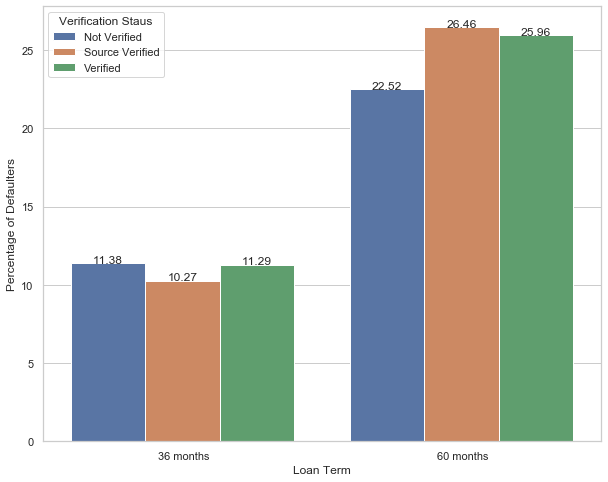

In [44]:
# Seeing the effect of Loan Term and Verification Status on Loan Repayment Status

# Get percentage of Loan Status in each of the Verification Status in Loan Term
term_verfn_count = loan.pivot_table(index = ['term', 'verification_status'], values = 'loan_status', aggfunc = {'verification_status': 'count'})  
loan_status_term_verfn_count = loan.pivot_table(index = ['term','verification_status', 'loan_status'], aggfunc = {'verification_status': 'count'})
loan_status_term_verfn_pcnt = loan_status_term_verfn_count * 100 / term_verfn_count

# Plot the table in a chart

# Reorganize the dataframe so that it can be plotted for all charged-off cases
loan_status_term_verfn_pcnt.rename({'verification_status':'verfn'}, axis='columns', inplace = True)
loan_status_term_verfn_pcnt.reset_index(inplace = True)
loan_status_term_verfn_pcnt = loan_status_term_verfn_pcnt.loc[loan_status_term_verfn_pcnt['loan_status'] == 'Charged Off']

# histogram plot
# set the seaborn theme
sns.set(style = "whitegrid")
# adjust figure size 
plt.figure(figsize = (10, 8))

purp_graph = sns.barplot(x = 'term', y = 'verfn', hue = 'verification_status', data = loan_status_term_verfn_pcnt)
plt.xlabel("Loan Term")
plt.ylabel("Percentage of Defaulters")
plt.legend(title = "Verification Staus")

# Get values of each bar
for p in purp_graph.patches:
    height = p.get_height()
    purp_graph.text(p.get_x()+p.get_width()/2., height, '{:1.2f}'.format(height), ha="center") 

plt.show()

From the table above, following inferences can be made:

- This does not provide any new answer that we already do not know (From Segmented Univariate Analysis of Verification Criteria and Loan Term)
- It says the same thing as the Segmented Univariate Analysis said: Borrowers with higher Loan Term tend to Default more and Borrowers with their income verified tend to Default more

5. `Home Ownership and Annual Income on Loan Status:`

- Group the Annual Income into bins to see the pattern of loan default or pay status
- Create bins for every 10th percentile of the annual income
- Also add one very low income (4,000 USD) and one one very high income (6,000,000 USD)
- Plot the values to analyze the pattern

In [45]:
# Analysis of Impact of Home Ownership and Annual Income on Loan Repayment Status:

# Create bins for every 10th percentile of the annual income for charged-off cases
# Also add one very low income (4,000 USD) and one one very high income (6,000,000 USD)
choff_annual_inc_bins = list(choff.annual_inc.quantile([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.99]))
choff_annual_inc_bins.append(6000000)
choff_annual_inc_bins.insert(0,4000)

# Create label for every bin created -> L1 to L11 signifying each level of income
choff_annual_inc_labels = []
for i in range(1, 12):
    choff_annual_inc_labels.append('L'+str(i))

# Get annual income and home ownership in a seperate dataframe
choff_annual_inc_ls = choff.loc[:,['annual_inc','home_ownership']]

# Add the income level labels to the dataframe and get the count of charged off in it
choff_annual_inc_ls['inc_level'] = pd.cut(choff_annual_inc_ls.annual_inc, bins = choff_annual_inc_bins, labels =choff_annual_inc_labels)
choff_annual_inc_ls = choff_annual_inc_ls.loc[:, ['inc_level', 'home_ownership']]
choff_annual_inc_ls = choff_annual_inc_ls.groupby(['inc_level', 'home_ownership']).size()
choff_annual_inc_ls = choff_annual_inc_ls.reset_index()
choff_annual_inc_ls.rename({0:'Charged Off'}, axis='columns', inplace = True)

# Convert the count into percentage of charged off cases in each home ownership for a given income level
# Get the sum in each income level
choff_inc_cnt = choff_annual_inc_ls.groupby('inc_level').sum().reset_index()
# Merge the sum in each income level with the count in each home ownership status
choff_annual_inc_ls = pd.merge(choff_annual_inc_ls, choff_inc_cnt, how = 'inner', on = 'inc_level')
# Now get the percentage of charged off cases in each home ownership for a given income level
choff_annual_inc_ls['Charged Off_x'] = round(100 * choff_annual_inc_ls['Charged Off_x'] / choff_annual_inc_ls['Charged Off_y'] , 2)
choff_annual_inc_ls = choff_annual_inc_ls.drop('Charged Off_y', axis=1)
choff_annual_inc_ls.rename({'Charged Off_x':'Charged Off'}, axis='columns', inplace = True)
choff_annual_inc_ls.style.format({'Charged Off':'{0:,.2f}%'})

,inc_level,home_ownership,Charged Off
0,L1,MORTGAGE,12.72%
1,L1,NONE,0.00%
2,L1,OTHER,0.18%
3,L1,OWN,14.13%
4,L1,RENT,72.97%
5,L2,MORTGAGE,21.13%
6,L2,NONE,0.00%
7,L2,OTHER,0.48%
8,L2,OWN,10.32%
9,L2,RENT,68.06%


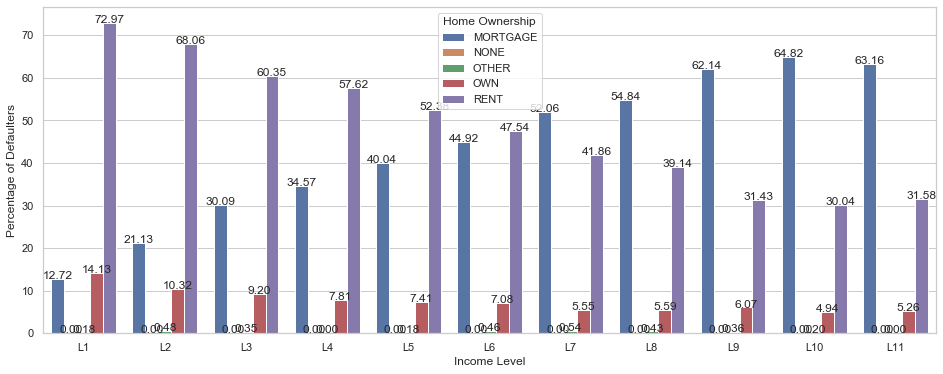

In [46]:
# Plot the above table in a chart

# set the seaborn theme
sns.set(style = "whitegrid")
# adjust figure size 
plt.figure(figsize=(16,6))

# Draw the Plot
ax = sns.barplot(y='Charged Off', x='inc_level', hue = 'home_ownership', data= choff_annual_inc_ls)
# Get values of each bar
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2., height, '{:1.2f}'.format(height), ha="center") 
    
plt.xlabel("Income Level")
plt.ylabel("Percentage of Defaulters")
plt.legend(title = "Home Ownership")

plt.show()

From the chart above, following inferences can be clearly seen:
- As the income level decreases, the borrowers living in Rented houses tend to default the loan more. Borrowers living in Own houses too exhibit the same behaviour but the default rate is not as prominent as borrowers living in Rented Houses
- As the income level increases, the borrowers living in Mortgaged houses tend to default the loan more

6. `Loan Amount and Others on Loan Status:`

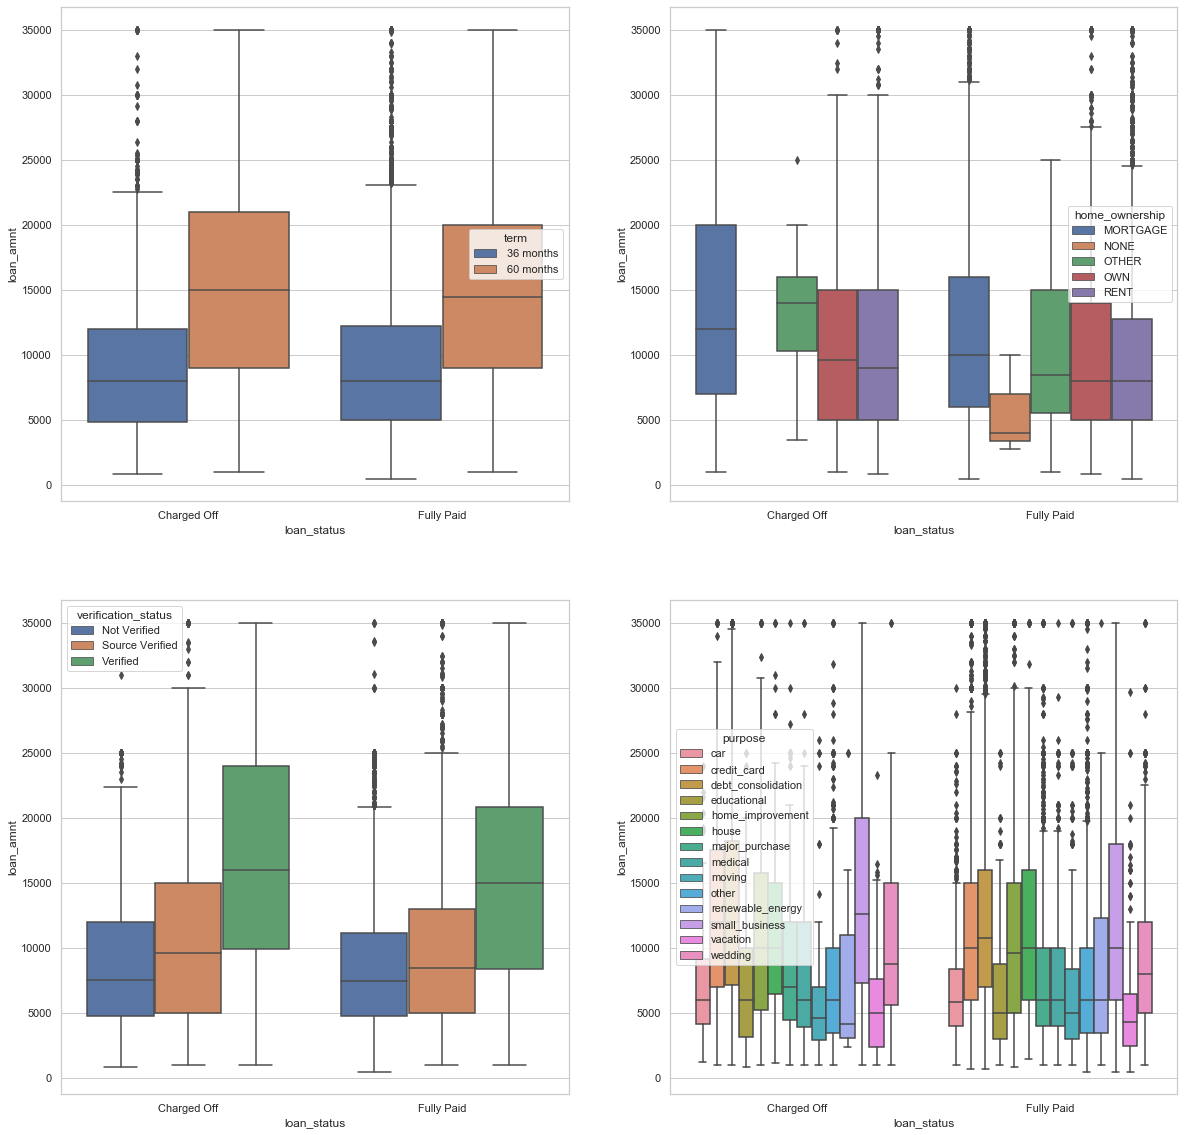

In [47]:
# See the effect of following combinations on Loan Status

# adjust figure size
plt.figure(figsize=(20, 20))
# Effect of Loan Amount and Term on Loan Status
plt.subplot(2,2,1)
sns.boxplot(x = 'loan_status', y = 'loan_amnt', hue = 'term', data = loan)
# Effect of Loan Amount and Home Ownership on Loan Status
plt.subplot(2,2,2)
sns.boxplot(x = 'loan_status', y = 'loan_amnt', hue = 'home_ownership', data = loan)
# Effect of Loan Amount and Verification Status on Loan Status
plt.subplot(2,2,3)
sns.boxplot(x = 'loan_status', y = 'loan_amnt', hue = 'verification_status', data = loan)
# Effect of Loan Amount and Loan Purpose on Loan Status
plt.subplot(2,2,4)
sns.boxplot(x = 'loan_status', y = 'loan_amnt', hue = 'purpose', data = loan)

plt.show()

- From the box plots above, drawing a conclusion on the effects of the combination of loan amount and another column is difficult
- Hence we will use other analysis methods (which have been already done above) to draw our conclusions

## Observations - Conclusions

### Segmented Univariate Analysis

#### DTI on Loan Repayment Status 
- Borrowers with DTI > 13.86 tend to default, those with < 13.21 tend to pay

#### Loan Amount on Loan Repayment Status 
- Borrowers with loan amount > 15,000 USD tend to default, those with < 15,000 USD tend to pay

#### Annual Income on Loan Repayment Status 
- Borrowers with annual income < 55,000 USD tend to default and those with > 65,000 USD tend to pay

#### Home Ownership on Loan Repayment Status
1. Borrowers with Rented Houses or Other as Home Ownership status tend do Default more than others
2. Borrowers with Mortgaged House or living in Own House tend to pay off the loan more than others

#### Loan Sub-Grade on Loan Repayment Status
1. Borrowers who have taken loan with Grade beyond D2 tend do Default more than others
2. Borrowers who have taken loan with Grade A or B tend to pay off the loan more than others

#### Employment Length on Loan Repayment Status
- No conclusions can be drawn

#### Loan Purpose on Loan Repayment Status
1. Borrowers who bought the loan for small business purpose tend to default the highest
2. Borrowers who bought the loan for renewable energy purpose tend to default more
3. Borrowers who bought the loan for major purchase and wedding purposes tend to fully pay the loan more

#### Loan Term on Loan Repayment Status
1. Borrowers who have taken the loan for 5 years are likely to default the loan
2. Borrowers who have taken the loan for 3 years are likely to fully pay the loan

#### State on Loan Repayment Status
1. Borrowers from the states Nevada and South Dakota are likely to default the loan
2. Borrowers from the states Washington D.C. and Wyoming are likely to fully pay the loan

#### Verification Status on Loan Repayment Status
- The result is as expected: Verified Borrowers tend to default more than Not Verified Borrowers

### Bivariate Analysis

#### Loan Amount and Annual Income on Loan Repayment Status
- No conclusions can be drawn

#### Loan Term and Loan Purpose on Loan Repayment Status
1. Borrowers who have taken loan for the purpose renewable energy and small business with 36 months tenure are more likely to default
2. Borrowers who have taken loan for the purpose educational and small business with 60 months tenure are more likely to default

#### Loan Term and Employment Length on Loan Repayment Status
- No conclusions can be drawn

#### Loan Term and Verification Status on Loan Repayment Status
- It says the same thing as the Segmented Univariate Analysis said: Borrowers with higher Loan Term tend to Default more and Borrowers with their income verified tend to Default more

#### Home Ownership and Annual Income on Loan Repayment Status
1. As the income level decreases, the borrowers living in Rented houses tend to default the loan more. Borrowers living in Own houses too exhibit the same behaviour but the default rate is not as prominent as borrowers living in Rented Houses
2. As the income level increases, the borrowers living in Mortgaged houses tend to default the loan more

#### Loan Amount and Others on Loan Status:
- No conclusions could be drawn